In [1]:
!pip install keras-tuner -q
!pip install lightgbm==3.2.0 -q

     |████████████████████████████████| 97 kB 2.7 MB/s 
     |████████████████████████████████| 2.0 MB 4.6 MB/s 


### Load dataset

In [2]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [3]:
X_train.shape, X_test.shape

((13209, 8), (4128, 8))

### Create the LightGBM model building function (search space)

In [4]:
def build_model(hp):
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        num_leaves=hp.Int("num_leaves", 5, 50, step=1),
        learning_rate=hp.Float('learning_rate', 1e-3, 1, sampling='log', default=0.01),
        n_estimators=hp.Int('n_estimators', 5, 50, step=1)
    )

    return model

### Customize tuner

In [5]:
import os
import pickle
import tensorflow as tf
import keras_tuner as kt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

class LightGBMTuner(kt.engine.base_tuner.BaseTuner):

    def run_trial(self, trial, X, y, validation_data):
        model = self.hypermodel.build(trial.hyperparameters) # build the model
        model.fit(X_train, y_train,
                eval_set=[validation_data],
                eval_metric='mse',
                early_stopping_rounds=5) # fit the model
        X_val, y_val = validation_data
        y_pred = model.predict(X_val, num_iteration=model.best_iteration_) # evaluate the model
        eval_mse = mean_squared_error(y_val, y_pred)
        self.oracle.update_trial(trial.trial_id, {'mse': eval_mse})  # inform the oracle of the eval result, the result is a dictionary with the metric names as the keys.
        self.save_model(trial.trial_id, model) # save the model to disk

    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), 'model.txt')
        model.booster_.save_model(fname, num_iteration=model.best_iteration_) 

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), 'model.txt')
        model = lgb.Booster(model_file=fname)
        return model

### Use customized evolutionary search algorithm to tune models

In [6]:
import random
import numpy as np
from keras_tuner.engine import hyperparameters as hp_module
from keras_tuner.engine import oracle as oracle_module
from keras_tuner.engine import trial as trial_lib


class EvolutionaryOracle(oracle_module.Oracle):
    """Evolutionary search oracle.

    It uses aging evluation algorithm following: https://arxiv.org/pdf/1802.01548.pdf.
    # Arguments
        objective: String or `kerastuner.Objective`. If a string,
          the direction of the optimization (min or max) will be
          inferred.
        max_trials: Int. Total number of trials
            (model configurations) to test at most.
            Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has been
            exhausted.
        num_initial_points: (Optional) Int. The number of randomly generated samples
            as initial training data for Evolutionary search. If not specified,
            a value of 3 times the dimensionality of the hyperparameter space is
            used.
        population_size: (Optional) Int. The number of trials to form the populations.
        candidate_size: (Optional) Int. The number of candidate trials in the tournament selection.
        seed: Int. Random seed.
        hyperparameters: HyperParameters class instance.
            Can be used to override (or register in advance)
            hyperparamters in the search space.
    """

    def __init__(self,
                 objective,
                 max_trials,
                 num_initial_points=None,
                 population_size=None,
                 candidate_size=None,
                 seed=None,
                 hyperparameters=None,
                 *args, **kwargs):
        super(EvolutionaryOracle, self).__init__(
            objective=objective,
            max_trials=max_trials,
            hyperparameters=hyperparameters,
            seed=seed,
            *args, **kwargs)
        self.population_size = population_size or 20
        self.candidate_size = candidate_size or 5
        self.num_initial_points = num_initial_points or self.population_size
        self.num_initial_points = max(self.num_initial_points, population_size) 
        self.population_trial_ids = []
        self.seed = seed or random.randint(1, 1e4)
        self._seed_state = self.seed
        self._random_state = np.random.RandomState(self.seed)
        self._max_collisions = 100

    def _random_populate_space(self):
        values = self._random_values()
        if values is None:
            return {'status': trial_lib.TrialStatus.STOPPED,
                    'values': None}
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def _num_completed_trials(self):
        return len([t for t in self.trials.values() if t.status == 'COMPLETED'])

    def populate_space(self, trial_id):

        if self._num_completed_trials() < self.num_initial_points:
            return self._random_populate_space()

        self.population_trial_ids = self.end_order[-self.population_size:]

        # candidate trial selection
        candidate_indices = self._random_state.choice(
                    self.population_size, self.candidate_size, replace=False
                )
        self.candidate_indices = candidate_indices
        candidate_trial_ids = list(
            map(self.population_trial_ids.__getitem__, candidate_indices)
        )

        # get the best candidate based on the performance
        candidate_scores = [self.trials[trial_id].score for trial_id in candidate_trial_ids]
        best_candidate_trial_id = candidate_trial_ids[np.argmin(candidate_scores)]
        best_candidate_trial = self.trials[best_candidate_trial_id]

        # mutate the hps of the candidate
        values = self._mutate(best_candidate_trial)

        if values is None:
            return {"status": trial_lib.TrialStatus.STOPPED, "values": None}

        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def _mutate(self, best_trial):

        best_hps = best_trial.hyperparameters

        # get non-fixed and active hyperparameters in the trial to be mutated
        nonfixed_active_hps = [hp for hp in self.hyperparameters.space
            if not isinstance(hp, hp_module.Fixed) and best_hps.is_active(hp)]

        # random select a hyperparameter to mutate
        hp_to_mutate =  self._random_state.choice(nonfixed_active_hps, 1)[0]

        collisions = 0
        while True:
            hps = hp_module.HyperParameters()
            # Generate a set of random values.
            for hp in self.hyperparameters.space:
                hps.merge([hp])
                # if not active, do nothing.
                # if active, check if selected to be changed.
                if hps.is_active(hp):
                    # if was active and not selected, do nothing.
                    if best_hps.is_active(hp.name) and hp.name != hp_to_mutate.name:
                        hps.values[hp.name] = best_hps.values[hp.name]
                        continue
                    # if was not active or selected, sample.
                    hps.values[hp.name] = hp.random_sample(self._seed_state)
                    self._seed_state += 1
            values = hps.values

            # Make sure the new hyperparameters has not been evaluated before
            # Keep trying until the set of values is unique,
            # or until we exit due to too many collisions.
            values_hash = self._compute_values_hash(values)
            if values_hash in self._tried_so_far:
                collisions += 1
                if collisions <= self._max_collisions:
                    continue
                return None
            self._tried_so_far.add(values_hash)
            break
        return values



      
    def get_state(self):
        state = super(EvolutionaryOracle, self).get_state()
        state.update({
            'num_initial_points': self.num_initial_points,
            'population_size': self.population_size,
            'candidate_size': self.candidate_size,
            'seed': self.seed,
            '_max_collisions': self._max_collisions,
        })
        return state

    def set_state(self, state):
        super(EvolutionaryOracle, self).set_state(state)
        self.num_initial_points = state['num_initial_points']
        self.population_size = state['population_size']
        self.candidate_size = state['candidate_size']
        self.population_trial_ids = self.end_order[-self.population_size:]
        self.seed = state['seed']
        self._random_state = np.random.RandomState(self.seed)
        self._seed_state = self.seed
        self._max_collisions = state['max_collisions']
        


In [9]:
evo_tuner_p20c5 = LightGBMTuner(
    oracle=EvolutionaryOracle(
        objective=kt.Objective('mse', 'min'),
        max_trials=100,
        population_size=20,
        candidate_size=5,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='evo_tuner_p20c5')

evo_tuner_p20c5.search(X_train, y_train, validation_data=(X_val, y_val))

random_tuner = LightGBMTuner(
    oracle=kt.oracles.RandomSearch(
        objective=kt.Objective('mse', 'min'),
        max_trials=100,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='random_tuner')
  
random_tuner.search(X_train, y_train, validation_data=(X_val, y_val))
  
  
bo_tuner = LightGBMTuner(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('mse', 'min'),
        max_trials=100,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='bo_tuner')
 
bo_tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 100 Complete [00h 00m 00s]
mse: 0.23597690339654237

Best mse So Far: 0.22488804973439655
Total elapsed time: 00h 04m 33s
INFO:tensorflow:Oracle triggered exit


In [10]:
from sklearn.metrics import mean_squared_error

best_model = random_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.22039670222190072


In [11]:
random_tuner.results_summary(1)

Results summary
Results in ./random_tuner
Showing 1 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
num_leaves: 33
learning_rate: 0.2678840060400965
n_estimators: 48
Score: 0.23615237093831826


In [12]:
from sklearn.metrics import mean_squared_error

best_model = bo_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.21867518662952914


In [13]:
bo_tuner.results_summary(1)

Results summary
Results in ./bo_tuner
Showing 1 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
num_leaves: 48
learning_rate: 0.21389616508982534
n_estimators: 50
Score: 0.22488804973439655


In [14]:
from sklearn.metrics import mean_squared_error

best_model = evo_tuner_p20c5.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.22128095525419533


In [15]:
evo_tuner_p20c5.results_summary(1)

Results summary
Results in ./evo_tuner_p20c5
Showing 1 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
num_leaves: 50
learning_rate: 0.1724562262786154
n_estimators: 47
Score: 0.23042379646704833


### Plot search curves

In [16]:
import matplotlib.pyplot as plt 

def plot_curve(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.show()

def plot_curves(x, ys, xlabel, ylabel, title, ymin, ymax, legend, markers, linestyles, markevery=1):
    for i, y in enumerate(ys):
        plt.plot(x, y, marker=markers[i], linestyle=linestyles[i], markevery=markevery)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.ylim(ymin, ymax)
    plt.legend(legend)
    plt.show()

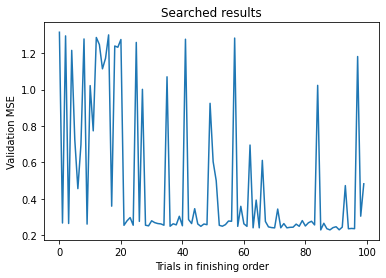

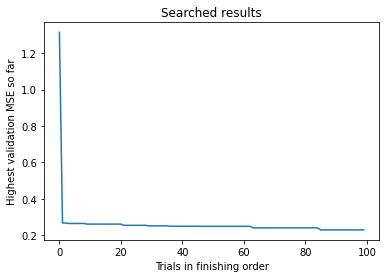

In [17]:
mse_evo = [evo_tuner_p20c5.oracle.get_trial(trial_id).score for trial_id in evo_tuner_p20c5.oracle.end_order]
ids = list(range(len(mse_evo)))
plot_curve(ids, mse_evo, 'Trials in finishing order', 'Validation MSE', 'Searched results')

high_value = float('inf')
high_mse_evo = []
for value in mse_evo:
  high_value = min(high_value, value)
  high_mse_evo.append(high_value)
plot_curve(ids, high_mse_evo, 'Trials in finishing order', 'Highest validation MSE so far', 'Searched results')

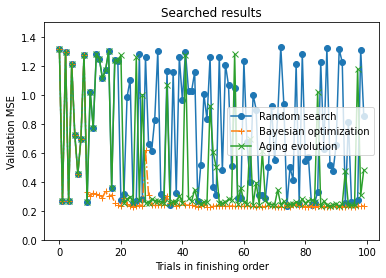

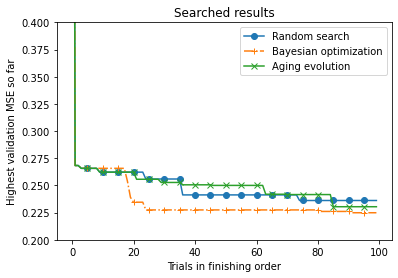

In [18]:
mse_random = [random_tuner.oracle.get_trial(trial_id).score for trial_id in random_tuner.oracle.end_order]
mse_bo = [bo_tuner.oracle.get_trial(trial_id).score for trial_id in bo_tuner.oracle.end_order]
mse_evo = [evo_tuner_p20c5.oracle.get_trial(trial_id).score for trial_id in evo_tuner_p20c5.oracle.end_order]


high_value = float('inf')
high_mse_random = []
for value in mse_random:
  high_value = min(high_value, value)
  high_mse_random.append(high_value)

high_value = float('inf')
high_mse_evo = []
for value in mse_evo:
  high_value = min(high_value, value)
  high_mse_evo.append(high_value)

high_value = float('inf')
high_mse_bo = []
for value in mse_bo:
  high_value = min(high_value, value)
  high_mse_bo.append(high_value)

plot_curves(ids, [mse_random, mse_bo, mse_evo], 'Trials in finishing order', 'Validation MSE', 'Searched results', 0, 1.5, markers=['o', '+', 'x'], linestyles=['-', '-.', '-'], legend=['Random search', 'Bayesian optimization', 'Aging evolution'])
plot_curves(ids, [high_mse_random, high_mse_bo, high_mse_evo], 'Trials in finishing order', 'Highest validation MSE so far', 'Searched results', 0.2, 0.4, markers=['o', '+', 'x'], linestyles=['-', '-.', '-'], legend=['Random search', 'Bayesian optimization', 'Aging evolution'], markevery=5)


### Try to increase the candidate size

In [19]:
evo_tuner_p20c10 = LightGBMTuner(
        oracle=EvolutionaryOracle(
            objective=kt.Objective('mse', 'min'),
            max_trials=100,
            population_size=20,
            candidate_size=20,
            seed=42),
        hypermodel=build_model,
        overwrite=True,
        project_name='evo_tuner_p20c10')

evo_tuner_p20c10.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 100 Complete [00h 00m 00s]
mse: 0.7692606371634233

Best mse So Far: 0.23144515844052233
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [20]:
from sklearn.metrics import mean_squared_error

best_model = evo_tuner_p20c5.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))

The prediction MSE on test set: 0.22128095525419533


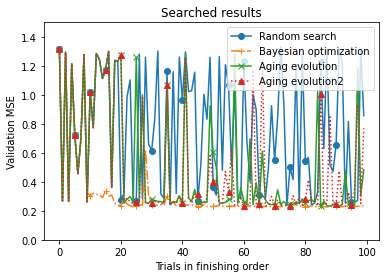

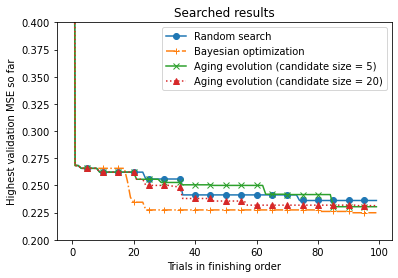

In [21]:
mse_evo_c10 = [evo_tuner_p20c10.oracle.get_trial(trial_id).score for trial_id in evo_tuner_p20c10.oracle.end_order]

high_value = float('inf')
high_mse_evo_c10 = []
for value in mse_evo_c10:
  high_value = min(high_value, value)
  high_mse_evo_c10.append(high_value)

plot_curves(ids, [mse_random, mse_bo, mse_evo, mse_evo_c10], 'Trials in finishing order', 'Validation MSE', 'Searched results', 0, 1.5,  markers=['o', '+', 'x', '^'], linestyles=['-', '-.', '-', ':'], legend=['Random search', 'Bayesian optimization', 'Aging evolution', 'Aging evolution2'], markevery=5)
plot_curves(ids, [high_mse_random, high_mse_bo, high_mse_evo, high_mse_evo_c10], 'Trials in finishing order', 'Highest validation MSE so far', 'Searched results', 0.2, 0.4,  markers=['o', '+', 'x', '^'], linestyles=['-', '-.', '-', ':'], legend=['Random search', 'Bayesian optimization', 'Aging evolution (candidate size = 5)', 'Aging evolution (candidate size = 20)'], markevery=5)
